# Лабораторная работа №5 по курсу<br>"Искусственный интеллект и машинное обучение":<br> Кластеризация данных
## Выполнил студент группы 6133-010402 Мелешенко Иван

# Задание на лабораторную работу

Выполнить кластеризацию данных вашего варианта использовав K-Means и его "soft" версию.<br>
Найти число кластеров при котором достигается наибольшее значение _purity_ для различных метрик расстояния:<br>

* Евклидово расстояние;
* Манхэттенское расстояние;
* Расстояние Чебышева;

Нарисовать графики метрик _purity_ и _DBI_ в зависимости от числа кластеров `K` для каждой из метрик расстояния. 


## Результаты, которые необходимо получить в итоге:

1. DataFrame, содержащий purity и DBI для каждой метрики расстония для лучшего параметра `K`.
2. График, показывающий зависимости между  purity и `K`, DBI и `K`.
3. Визуализация кластеризации лучшей вашей модели.

# Этапы работы

1. Описание алгоритмов
2. Описание метрик
3. Обработка входных данных
4. Кластеризация данных
5. Обработка результатов кластеризации
6. Обощение результатов лабораторной работы

# 0. Начало работы

## Подключение необходимых библиотек.

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(6)

# 1. Описание алгоритмов

В данной работе для кластеризации данных будет использоваться алгоритмы 
* `k-means`
* `soft k-means`

Код указанных алгоритмов использован из методического пособия для выполнения данной лабораторной работы.

## 1.2. Описание алгоритма `k-means`

In [3]:
def algorithm_k_means(X, K, dist, max_iter=20):
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Метки
    L = np.zeros(N)
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    M_prev = M.copy()
    for i in range(max_iter):
        dists = []
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            dists += [dist(X, M[k]).reshape(-1, 1)]
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        # Найдем ближайший кластер для каждой точки (шаг 2)
        L = np.argmin(dists, axis=1)
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = X[L==k].mean(axis=0)
            
        # Проверим условие сходимости
        if np.allclose(M, M_prev):
            print(f'KMeans converged on {i}th iteration')
            break
        else:
            M_prev = M.copy()
    
    return M, L

## 1.3. Описание алгоритма `soft k-means`

In [4]:
def algorithm_soft_k_means(X, K, dist, max_iter=20):
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Матрица принадлежности.
    # R[i, j] = вероятность того что `i` точка принадлежит кластеру `j`
    # или пренадлежность кластера `j` точке `i`
    R = np.zeros((N, K))
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Массив значений ошибок
    losses = []
    
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    for i in range(max_iter):
        dists = []
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            dists += [dist(X, M[k]).reshape(-1, 1)]
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        
        # Вычислим значения принадлежностей точек кластерам (шаг 2)
        R = cluster_resp(dists)
        
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
            
        losses.append(loss(X, M, R, dist))
            
        # Проверим условие сходимости
        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) < 1e-6:
            print(f'KMeans converged on {i}th iteration')
            break
        
    colors = np.random.random((K,3))
    p_colors = R.dot(colors)
    return M, R, losses

# 2. Описание метрик

Для работы оценки алгоритмов кластеризации нам потребуются метрики. В данной работе используется два вида метрик:
* `метрики расстояний для работы алгоритмов`
* `метрики оценки качества алгоритма`

## 2.1. Описание метрик оценки

Коды метрик оценки реализованы, согласно коду представленному в методическом пособии по лабораторной работе №5.

### 2.1.1 Описание метрики Loss для оценки модели

In [5]:
def loss(X, M, R, dist):
    loss = 0
    for k in range(len(M)):
        d = dist(X, M[k])
        loss += np.sum(R[:,k] * (d * d))
    return loss

### 2.1.2. Описание метрики Cluster Responsibilities для вычисления значения (или оценки) принадлежности точек кластерам

In [6]:
def cluster_resp(distances):
    d_exp = np.exp(-distances)
    p=np.sum(d_exp, axis=1, keepdims=True)
    for i in range(0,len(p)):
        if(p[i]==0):
            p[i]=0.5
    result = d_exp / p
    return result

### 2.1.3. Описание внешней метрики оценки - `purity metrics`

In [7]:
def purity_metric(class_labels, cluster_labels):
  c_m = contingency_matrix(class_labels, cluster_labels)
  return np.sum(np.amax(c_m, axis=0)) / np.sum(c_m)

### 2.1.4. Описание внутренней  метрики оценки - `Davies-Bouldin Index (Индекс Дэвиса-Болдина)`

In [8]:
def davies_bouldin_metric(X, cluster_labels, distance):
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / distance(centroids[i], centroids[j]))

    return(np.max(db) / n_cluster)

## 2.2. Описание метрик расстояния

Коды метрик расстояния были реализованы, согласно кода, представленного в методическом пособии по лабораторной работе №5.<br>
А так же были подключены, стандартные метрики расстояний представленные в библиотеке `scipy.spatial.distance`

### A.Описание собственных метрик

#### A.1. Описание метрики Евклидово расстояние, реализованной с использованием формулы.

In [9]:
def euclidean_distance(x, y):
    difference = x - y
    distance = np.sum(difference * difference, axis=-1)
    return np.sqrt(distance)

#### A.2. Описание метрики Манхэттенское расстояние, реализованной с использованием формулы.

In [10]:
def manhattan_distance(x, y): 
  difference = x - y
  distance = np.sum(np.abs(difference),axis=-1)
  return distance

#### A.3. Описание метрики Расстояние Чебышева, реализованной с использованием формулы.

In [11]:
def chebyshev_distance(x, y): 
  difference = x - y
  distance = np.max(np.abs(difference),axis=-1)
  return distance

### B. Метрики из библиотек

#### B.1. Метрика Евклидово расстояние

In [12]:
from scipy.spatial.distance import euclidean

#### B.2. Метрика Манхэттенское расстояние

In [13]:
from scipy.spatial.distance import cityblock

#### B.3. Метрика Расстояние Чебышева

In [14]:
from scipy.spatial.distance import chebyshev 

# 3. Обработка данных

## 3.1. Загрузка данных

Для ускорения процесса загрузки файлов в программу воспользуемся Google Drive, поскольку его использование существенно снижает временные расходы на загрузку файлов.

### Монтирование образа Google Drive

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Загрузка данных в переменные

In [74]:
from numpy import load
specter = load('/content/drive/MyDrive/14.npy')
mask = load('/content/drive/MyDrive/14_mask.npy')

## 3.2. Предобработка данных

Произведем обработку входных данных, для последующего использования в программе.<br>
Код, осуществялющий обработку входных данных, использован из четвертой лабораторной работы.

In [75]:
height = specter.shape[0]
width = specter.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

In [76]:
x = []
y = []
for idx in ordered_positions:
    x.append(specter[idx[0], idx[1], ::])
    y.append(mask[idx[0], idx[1]]) 

In [77]:
specter = np.array(x, copy=False)
mask = np.array(y, copy=False)

## 3.3. Создание DataFrame

Создадим датафреймы для последующей обработки данных.

In [20]:
results_k_means = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
results_soft_k_means = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
best_purity = 0
best_L = np.array([])

Числовые значения количества кластеров, для проведения экспериментов.

In [21]:
initial_number_clusters = 2
finite_number_clusters = 11
number_cluster = []
for i in range(initial_number_clusters, finite_number_clusters, 2):
  number_cluster.append(i)

Массивы для сохранения значений, которые будут в последующем использоавны для построения графиков.

In [22]:
purity_k_means_euclidean = []
purity_k_means_manhattan = []
purity_k_means_chebyshev = []
purity_soft_k_means_euclidean = []
purity_soft_k_means_manhattan = []
purity_soft_k_means_chebyshev = []
dbi_k_means_euclidean = []
dbi_k_means_manhattan = []
dbi_k_means_chebyshev = []
dbi_soft_k_means_euclidean = []
dbi_soft_k_means_manhattan = []
dbi_soft_k_means_chebyshev = []

# 4. Кластеризация

## 4.1. Кластеризация алгоритмом k-means

### 4.1.1. Euclidean distance

In [23]:
results_k_means_euclidean = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:  
  M, L = algorithm_k_means(specter, K, euclidean_distance)

  purity = purity_metric(mask, L)
  purity_k_means_euclidean.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, euclidean)
  dbi_k_means_euclidean.append(dbi)
  results_k_means_euclidean = results_k_means_euclidean.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'euclidean',
      'clustering': 'k_means',
      }, ignore_index=True)

KMeans converged on 8th iteration


### 4.1.2. Manhattan distance

In [24]:
results_k_means_manhattan = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:
  M, L = algorithm_k_means(specter, K, manhattan_distance)  
  purity = purity_metric(mask, L)
  purity_k_means_manhattan.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, cityblock)
  dbi_k_means_manhattan.append(dbi)
  results_k_means_manhattan = results_k_means_manhattan.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'manhattan',
      'clustering': 'k_means',
      }, ignore_index=True)

KMeans converged on 19th iteration


### 4.1.3. Chebyshev distance

In [25]:
results_k_means_chebyshev = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:
  M, L = algorithm_k_means(specter, K, chebyshev_distance)  
  purity = purity_metric(mask, L)
  purity_k_means_chebyshev.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, chebyshev)
  dbi_k_means_chebyshev.append(dbi)
  results_k_means_chebyshev = results_k_means_chebyshev.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'chebyshev',
      'clustering': 'k_means',
      }, ignore_index=True)

KMeans converged on 8th iteration


## 4.2. Кластеризация алгоритмом soft k-means

### 4.2.1. Euclidean distance

In [26]:
results_soft_k_means_euclidean = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:  
  M, R, losses = algorithm_soft_k_means(specter, K, euclidean_distance)
  L = np.argmax(R, axis=1)
  purity = purity_metric(mask, L)
  purity_soft_k_means_euclidean.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, euclidean)
  dbi_soft_k_means_euclidean.append(dbi)
  results_soft_k_means_euclidean = results_soft_k_means_euclidean.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'euclidean',
      'clustering': 'soft_k_means',
      }, ignore_index=True)

### 4.2.2. Manhattan distance

In [27]:
results_soft_k_means_manhattan = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:  
  M, R, losses = algorithm_soft_k_means(specter, K, manhattan_distance)
  L = np.argmax(R, axis=1)
  purity = purity_metric(mask, L)
  purity_soft_k_means_manhattan.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, cityblock)
  dbi_soft_k_means_manhattan.append(dbi)
  results_soft_k_means_manhattan = results_soft_k_means_manhattan.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'manhattan',
      'clustering': 'soft_k_means',
      }, ignore_index=True)

### 4.2.3. Chebyshev distance

In [28]:
results_soft_k_means_chebyshev = pd.DataFrame(columns=['K', 'purity', 'davies_bouldin', 'distance', 'clustering'])
for K in number_cluster:  
  M, R, losses = algorithm_soft_k_means(specter, K, chebyshev_distance)
  L = np.argmax(R, axis=1)
  purity = purity_metric(mask, L)
  purity_soft_k_means_chebyshev.append(purity)
  if purity > best_purity:
    best_purity = purity 
    best_L = L
  dbi = davies_bouldin_metric(specter, L, chebyshev)
  dbi_soft_k_means_chebyshev.append(dbi)
  results_soft_k_means_chebyshev = results_soft_k_means_chebyshev.append({
      'K': K,
      'purity': purity,
      'davies_bouldin': dbi,
      'distance': 'chebyshev',
      'clustering': 'soft_k_means',
      }, ignore_index=True)

# 5. Обработка результатов кластеризации

## 5.1 Описание функции, для обработки данных

In [29]:
def calcAndChoiceResult(resultDataFrame):
  resultDataFrame = resultDataFrame.sort_values('purity', ascending=False)
  sequence = []
  for i in range(0, len(number_cluster)):
    sequence.append(i)
  resultDataFrame = resultDataFrame.set_index(pd.Series(sequence))
  resultDataFrame = resultDataFrame.drop(resultDataFrame.index.to_list()[1:] ,axis = 0 )
  return resultDataFrame;

## 5.2 Опеределние лучших результатов кластеризации для алгоритма `k_means`

In [30]:
results_k_means_euclidean = calcAndChoiceResult(results_k_means_euclidean)
results_k_means_manhattan = calcAndChoiceResult(results_k_means_manhattan)
results_k_means_chebyshev = calcAndChoiceResult(results_k_means_chebyshev)

## 5.3. Сборка лучших результатов кластеризации для алгоритма `k_means` в единый `DataFrame`.

In [31]:
results_k_means = pd.concat([results_k_means_euclidean, results_k_means_manhattan, results_k_means_chebyshev]).sort_index()

## 5.4 Опеределние лучших результатов кластеризации для алгоритма `soft_k_means`

In [32]:
results_soft_k_means_euclidean = calcAndChoiceResult(results_soft_k_means_euclidean)
results_soft_k_means_manhattan = calcAndChoiceResult(results_soft_k_means_manhattan)
results_soft_k_means_chebyshev = calcAndChoiceResult(results_soft_k_means_chebyshev)

## 5.5. Сборка лучших результатов кластеризации для алгоритма `soft_k_means` в единый `DataFrame`.

In [33]:
results_soft_k_means = pd.concat([results_soft_k_means_euclidean, results_soft_k_means_manhattan, results_soft_k_means_chebyshev]).sort_index()

# 6. Обощение результатов лабораторной работы

## <center> 6.1. DataFrame, содержащий purity и DBI<br>для каждой метрики расстония для лучшего параметра `K`. </center>

In [34]:
results = pd.concat([results_k_means, results_soft_k_means]).sort_index()
results = results.sort_values('purity', ascending=False)
sequence_best = []
for i in range(0, 6):
  sequence_best.append(i)
results = results.set_index(pd.Series(sequence_best))
results

,K,purity,davies_bouldin,distance,clustering
0,10,0.751690,0.127024,euclidean,k_means
1,10,0.749073,0.112223,euclidean,soft_k_means
2,10,0.746925,0.131107,chebyshev,k_means
3,10,0.746494,0.152504,manhattan,k_means
4,10,0.746361,0.145764,chebyshev,soft_k_means
5,8,0.615128,0.340183,manhattan,soft_k_means


## <center> 6.2. График, показывающий зависимости между  purity и `K`, DBI и `K`.</center>

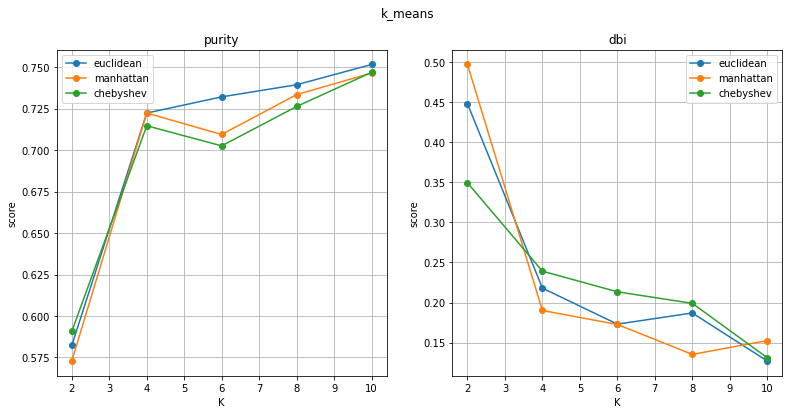

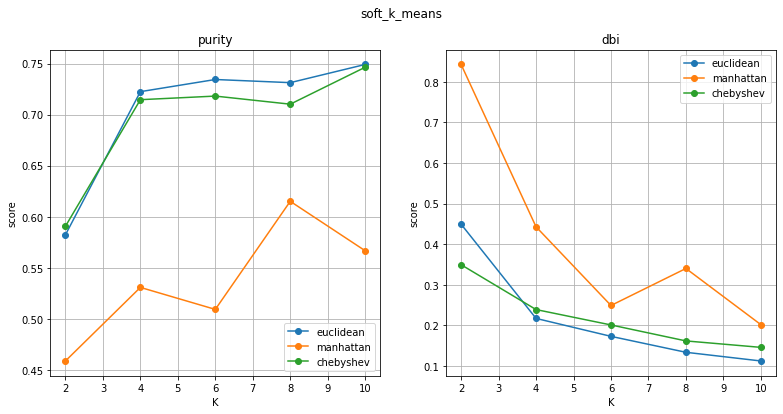

In [36]:
cluster_method = ['k_means', 'soft_k_means']
estimation_method = ['purity', 'dbi']
distance_method = ['euclidean', 'manhattan', 'chebyshev']
for cluster in cluster_method:
  plt.figure(figsize=(13, 6))
  i = 1
  for estimations in estimation_method:
    plt.subplot(1, 2, i)
    plt.title(estimations)  
    for distances in distance_method:
      if(cluster is 'k_means'):
        if(estimations is 'purity'): 
          if(distances is 'euclidean'):
            plt.plot(number_cluster, purity_k_means_euclidean, 'o-', label = 'euclidean')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'manhattan'):
            plt.plot(number_cluster, purity_k_means_manhattan, 'o-', label = 'manhattan')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'chebyshev'):
            plt.plot(number_cluster, purity_k_means_chebyshev, 'o-', label = 'chebyshev')
            plt.legend()
            plt.grid()
            i += 1
            plt.xlabel('K')
            plt.ylabel('score')
        if(estimations is 'dbi'): 
          if(distances is 'euclidean'):
            plt.plot(number_cluster, dbi_k_means_euclidean, 'o-', label = 'euclidean')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'manhattan'):
            plt.plot(number_cluster, dbi_k_means_manhattan, 'o-', label = 'manhattan')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'chebyshev'):
            plt.plot(number_cluster, dbi_k_means_chebyshev, 'o-', label = 'chebyshev')
            plt.legend()
            plt.grid()
            i += 1
            plt.xlabel('K')
            plt.ylabel('score')
      if(cluster is 'soft_k_means'):
        if(estimations is 'purity'): 
          if(distances is 'euclidean'):
            plt.plot(number_cluster, purity_soft_k_means_euclidean, 'o-', label = 'euclidean')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'manhattan'):
            plt.plot(number_cluster, purity_soft_k_means_manhattan, 'o-', label = 'manhattan')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'chebyshev'):
            plt.plot(number_cluster, purity_soft_k_means_chebyshev, 'o-', label = 'chebyshev')
            plt.legend()
            plt.grid()
            i += 1
            plt.xlabel('K')
            plt.ylabel('score')
        if(estimations is 'dbi'): 
          if(distances is 'euclidean'):
            plt.plot(number_cluster, dbi_soft_k_means_euclidean, 'o-', label = 'euclidean')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'manhattan'):
            plt.plot(number_cluster, dbi_soft_k_means_manhattan, 'o-', label = 'manhattan')
            plt.legend()
            plt.grid()
            plt.xlabel('K')
            plt.ylabel('score')
          if(distances is 'chebyshev'):
            plt.plot(number_cluster, dbi_soft_k_means_chebyshev, 'o-', label = 'chebyshev')
            plt.legend()
            plt.grid()
            i += 1
            plt.xlabel('K')
            plt.ylabel('score')
  plt.suptitle(cluster)
  plt.show()

## <center> 6.3. Визуализация кластеризации лучшей вашей модели. </center>

Исходя из полученных графиков выше, можно сказать что лучшей моделью является .
* k_means
* euclidean_distances
* count cluster = 10

Ее и визуализируем.

Text(0.5, 1.0, 'clusterisations')

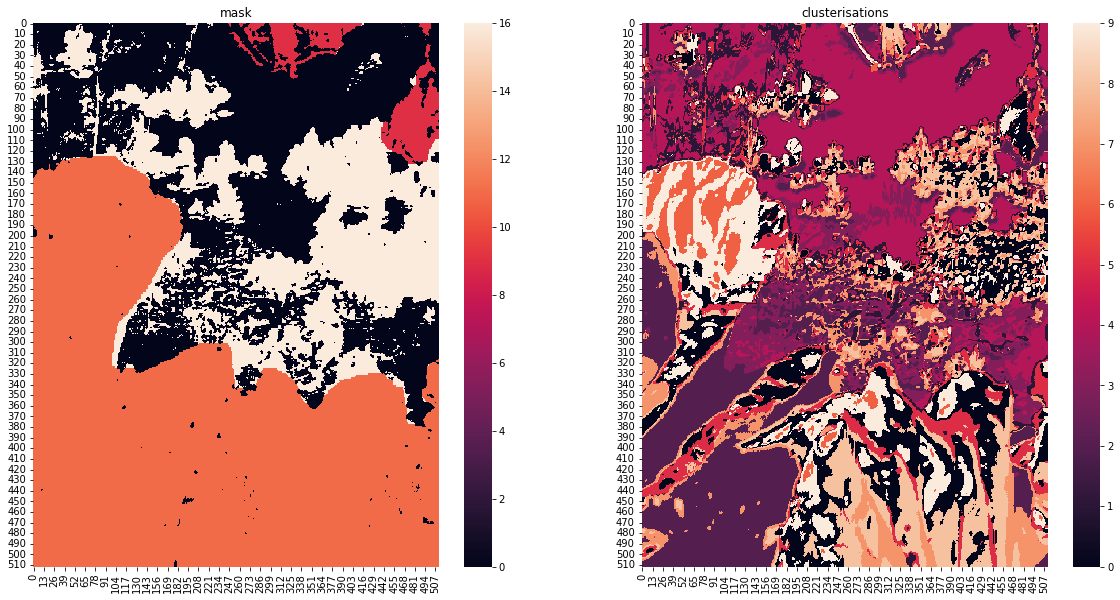

In [87]:
mask = load('/content/drive/MyDrive/14_mask.npy')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
mask = mask.reshape(-1)
M, best_L = algorithm_k_means(specter, 10, euclidean_distance)
sns.heatmap(mask.base, ax=ax1)
sns.heatmap(best_L.reshape((512,512)), ax=ax2)
ax1.set_title('mask')
ax2.set_title('clusterisations')